In [41]:
import jax
import jax.numpy as jnp
import jaxlib
import optax
import haiku as hk
import gym

In [42]:
env = gym.make('LunarLander-v2', new_step_api=True)
print(env.action_space.n)

4


In [43]:
NUM_ACTIONS = env.action_space.n


## What we need

- [x] Environment 
- [] Memory Buffer
- [] DQN model
- [] loss function
- [] Training Loop


In [44]:
class TrainConfig:
    MEMORY_SIZE = 10000
    BATCH_SIZE = 32
    UPDATE_PARAMS_EVERY_N_STEPS = 4
    TAU = 0.001
    E_MIN = 0.01
    E_DECAY = 0.995
    N_EPISODES = 1
    MAX_N_STEPS_PER_EPISODE = 1000
    

In [45]:
import dataclasses
from typing import NamedTuple
from collections import deque


@dataclasses.dataclass
class Experience:
    state: jnp.ndarray
    action: int
    reward: float
    next_state: jnp.ndarray
    done: bool


memory = deque(maxlen=TrainConfig.MEMORY_SIZE)

## What we need

- [x] Environment 
- [x] Memory Buffer
- [] DQN model
- [] loss function
- [] Training Loop


In [46]:
from typing import NamedTuple
# @dataclasses.dataclass
class TrainingState(NamedTuple):
    params: hk.Params
    target_params: hk.Params
    eval_params: hk.Params
    opt_state: optax.OptState

# @dataclasses.dataclass
class Batch(NamedTuple):
    states: jnp.ndarray
    actions: int
    rewards: float
    next_states: jnp.ndarray
    dones: bool



def network_fn(x: jnp.ndarray) -> jnp.ndarray:
    model = hk.Sequential(
        [
            hk.Linear(64),jax.nn.relu,
            hk.Linear(64), jax.nn.relu,
            hk.Linear(NUM_ACTIONS),
        ]

    )
    return model(x)

network = hk.without_apply_rng(hk.transform(network_fn))
target_network = hk.without_apply_rng(hk.transform(network_fn))
optimiser = optax.adam(1e-3)
# Initialise network and optimiser; note we draw an input to get shapes.

In [47]:
import jax.random as jrandom
import random
import numpy as np
keygen = jrandom.PRNGKey(0)

def get_random_batch(memory):
    batch = random.sample(memory, k=TrainConfig.BATCH_SIZE)
    return Batch(
        states=jnp.array([e.state for e in batch]),
        actions=jnp.array([e.action for e in batch]),
        rewards=jnp.array([e.reward for e in batch]),
        next_states=jnp.array([e.next_state for e in batch]),
        dones=jnp.array([e.done for e in batch]),
    )

small_memory = deque(maxlen=1000)

state = env.reset()
action = env.action_space.sample()
for _ in range(200):
    action = env.action_space.sample()
    next_state, reward, is_done, *_ = env.step(action)
    experience = Experience(state, action, reward, next_state, is_done)
    small_memory.append(experience)

batch = get_random_batch(small_memory)

batch.states.shape

(32, 8)

In [48]:

initial_params = network.init(
    jax.random.PRNGKey(seed=0), batch.states)
initial_opt_state = optimiser.init(initial_params)
train_state = TrainingState(initial_params, initial_params, initial_params, initial_opt_state)

## What we need

- [x] Environment 
- [x] Memory Buffer
- [x] DQN model
- [] loss function
- [] Training Loop


In [49]:
# def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
params = train_state.params
state_actions_values = network.apply(params, batch.next_states)
max_state_actions_values = jnp.max(state_actions_values, axis=1)
targets = batch.rewards + jnp.where(batch.dones, 0.0, max_state_actions_values)

q_values = network.apply(params, batch.states)



In [50]:
q_values.shape

(32, 4)

In [51]:

q_value_for_action_taken = q_values[jnp.arange(q_values.shape[0]), batch.actions]


In [52]:
print(q_values[0])
print(batch.actions[0])
print(q_value_for_action_taken[0])
assert q_value_for_action_taken[0] == q_values[0][batch.actions[0]]

[0.29389054 0.10932146 0.14178142 0.0214625 ]
0
0.29389054


In [53]:
def loss(params, target_params, batch):
    q_values = network.apply(params, batch.states)
    q_values_pred = q_values[jnp.arange(q_values.shape[0]), batch.actions]

    q_values_next = target_network.apply(target_params, batch.next_states)
    q_values_next_max = jnp.max(q_values_next, axis=1)

    q_value_true = batch.rewards + jnp.where(batch.dones, 0.0, q_values_next_max)
    return jnp.mean((q_values_pred - q_value_true) ** 2)

In [54]:
@jax.jit
def update(train_state: TrainingState, batch: Batch) -> TrainingState:
    """Learning rule (stochastic gradient descent)."""
    grads = jax.grad(loss)(train_state.params, train_state.target_params, batch)
    updates, opt_state = optimiser.update(grads, train_state.opt_state)
    params = optax.apply_updates(train_state.params, updates)

    # Update target network.
    # params * TAU + (1 - TAU) * new_params
    # target_params = params * TrainConfig.TAU  + (1 - TrainConfig.TAU) * train_state.target_params
    target_params = optax.incremental_update(params, train_state.target_params, TrainConfig.TAU)
    
    # Compute avg_params, the exponential moving average of the "live" params.
    # We use this only for evaluation (cf. https://doi.org/10.1137/0330046).
    eval_params = optax.incremental_update(
        params, train_state.eval_params, step_size=0.001)
    return TrainingState(params, target_params, eval_params, opt_state)

In [55]:
state = env.reset()
batch_state = jnp.array([state, state])
network.apply(train_state.params, state)
network.apply(train_state.params, batch_state)

DeviceArray([[0.30787027, 0.00703829, 0.08828568, 0.01972442],
             [0.30787027, 0.00703829, 0.08828568, 0.01972442]],            dtype=float32)

In [56]:

def update_epsilon(epsilon, train_config: TrainConfig):
    return max(train_config.E_MIN, train_config.E_DECAY*epsilon)

def exploit_or_explore(q_value: jnp.ndarray, epsilon: float = 0.1) -> int:
    """Exploit or explore according to epsilon-greedy policy."""
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.array(jnp.argmax(q_value))

def is_update_params(n_steps_taken: int, train_config: TrainConfig) -> bool:
    """Update params every `update_params_every` steps."""
    return (n_steps_taken + 1) % train_config.UPDATE_PARAMS_EVERY_N_STEPS == 0


In [57]:
    
total_reward_history = []
moving_average_window_size = 100
epsilon = 1.0
train_config = TrainConfig()
for episode in range(train_config.N_EPISODES):
    state = env.reset()
    total_reward = 0.0

    for step in range(train_config.MAX_N_STEPS_PER_EPISODE):
        q_value = network.apply(train_state.params, state)
        action = exploit_or_explore(q_value=q_value, epsilon=epsilon)
        
        next_state, reward, is_done, *_ = env.step(action)
        experience = Experience(state, action, reward, next_state, is_done)
        memory.append(experience)
        if len(memory) < TrainConfig.MEMORY_SIZE:
            state = next_state
            total_reward += reward
            if is_done:
                break
            continue

        if is_update_params(step, train_config=train_config):
            batch =get_random_batch(memory)
            train_state = update(train_state, batch)

        state = next_state
        total_reward += reward
        if is_done:
            break

    total_reward_history.append(total_reward)
    mean_total_reward_in_window = np.mean(total_reward_history[-moving_average_window_size:])
    epsilon = update_epsilon(epsilon, train_config)


    print(f"\rEpisode {episode+1} | Total point average of the last {moving_average_window_size} episodes: {mean_total_reward_in_window:.2f}", end="")

    if (episode+1) % moving_average_window_size == 0:
        print(f"\rEpisode {episode+1} | Total point average of the last {moving_average_window_size} episodes: {mean_total_reward_in_window:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if mean_total_reward_in_window >= 200.0:
        print(f"\n\nEnvironment solved in {episode+1} episodes!")
        # q_network.save('lunar_lander_model.h5')
        break

Episode 1 | Total point average of the last 100 episodes: -161.17

In [58]:
import base64
import imageio
import IPython

def create_video(filename, env, train_state, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()
        frame = env.render(mode="rgb_array")
        video.append_data(frame)
        while not done:    
            q_values = network.apply(train_state.params, state)
            action = jnp.argmax(q_values)
            state, _, done, *_ = env.step(np.asarray([action])[0])
            frame = env.render(mode="rgb_array")
            video.append_data(frame)



In [59]:
from IPython.display import Video
filename = "./lunar_lander.mp4"
create_video(filename, env, train_state)
Video(filename)

/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
[swscaler @ 0x57885c0] Warning: data is not aligned! This can lead to a speed loss


In [60]:
import tensorflow as tf
import tree
from jax.experimental import jax2tf
import sonnet as snt



def create_variable(path, value):
  name = '/'.join(map(str, path)).replace('~', '_')
  return tf.Variable(value, name=name)
N_FEATURES_PER_STATE = 8
polymorphic_state_shape = jax2tf.shape_poly.PolyShape(
  "b", N_FEATURES_PER_STATE
)

class JaxModule(snt.Module):
  def __init__(self, params, apply_fn, name=None):
    super().__init__(name=name)
    self._params = tree.map_structure_with_path(create_variable, params)
    # self._apply = jax2tf.convert(lambda p, x: apply_fn(p, x), polymorphic_shapes=[None, "b, 8"])
    self._apply = jax2tf.convert(lambda p, x: apply_fn(p, x), polymorphic_shapes=[None, polymorphic_state_shape])
    self._apply = tf.autograph.experimental.do_not_convert(self._apply)

  def __call__(self, inputs):
    return self._apply(self._params, inputs)


# network = hk.without_apply_rng(hk.transform(network_fn))
# target_network = hk.without_apply_rng(hk.transform(network_fn))
# optimiser = optax.adam(1e-3)
# initial_params = network.init(
#     jax.random.PRNGKey(seed=0), batch.states)
net = JaxModule(train_state.params, network.apply)
[v.name for v in net.trainable_variables]



/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/tensorflow/__init__.py:29: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils as _distutils
2022-08-22 12:15:41.382768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp
/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/keras/utils/image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST o

['jax_module/linear/b:0',
 'jax_module/linear/w:0',
 'jax_module/linear_1/b:0',
 'jax_module/linear_1/w:0',
 'jax_module/linear_2/b:0',
 'jax_module/linear_2/w:0']

In [61]:
network.apply(initial_params, state)

/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


DeviceArray([ 0.46667343, -0.03591029, -0.29230744, -0.16951452], dtype=float32)

In [62]:

@tf.function(autograph=False, input_signature=[tf.TensorSpec([None, 8])])
def forward(x):
  return net(x)

to_save = tf.Module()
to_save.forward = forward
to_save.params = list(net.variables)

In [63]:
tf.saved_model.save(to_save, "./lunar_lander_model")

/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


In [64]:
loaded = tf.saved_model.load("./lunar_lander_model/")
preds = loaded.forward(tf.ones([3, 8]))
preds_with_serving_default = loaded.signatures['serving_default'](x=tf.ones([2,8]))

In [65]:
state

array([-0.5280086 , -0.14223678, -0.32590032, -0.2560407 ,  0.36866826,
       -3.6965518 ,  0.        ,  1.        ], dtype=float32)

In [66]:
import tensorflow as tf
loaded = tf.saved_model.load("./lunar_lander_model/")

# Trading RL


In [89]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import jaxlib
import optax
import haiku as hk
import gym
import dataclasses
from typing import NamedTuple
from collections import deque


# @dataclasses.dataclass
class TrainingState(NamedTuple):
    params: hk.Params
    target_params: hk.Params
    eval_params: hk.Params
    opt_state: optax.OptState

# @dataclasses.dataclass
class Batch(NamedTuple):
    states: jnp.ndarray
    actions: int
    rewards: float
    next_states: jnp.ndarray
    dones: bool




@dataclasses.dataclass
class Experience:
    state: jnp.ndarray
    action: int
    reward: float
    next_state: jnp.ndarray
    done: bool

class TrainConfig:
    MEMORY_SIZE = 10000
    BATCH_SIZE = 32
    UPDATE_PARAMS_EVERY_N_STEPS = 4
    TAU = 0.001
    E_MIN = 0.01
    E_DECAY = 0.995
    N_EPISODES = 10000
    MAX_N_STEPS_PER_EPISODE = 1000
    

keygen = jrandom.PRNGKey(0)

def get_random_batch(memory):
    batch = random.sample(memory, k=TrainConfig.BATCH_SIZE)
    return Batch(
        states=jnp.array([e.state for e in batch]),
        actions=jnp.array([e.action for e in batch]),
        rewards=jnp.array([e.reward for e in batch]),
        next_states=jnp.array([e.next_state for e in batch]),
        dones=jnp.array([e.done for e in batch]),
    )

NUM_ACTIONS = 2
def network_fn(x: jnp.ndarray) -> jnp.ndarray:
    model = hk.Sequential(
        [
            hk.Flatten(),
            hk.Linear(64),jax.nn.relu,
            hk.Linear(64), jax.nn.relu,
            hk.Linear(NUM_ACTIONS),
        ]

    )
    return model(x)



In [90]:
env.action_space

Discrete(2)

In [91]:
import gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from collections import deque
import random

env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

small_memory = deque(maxlen=1000)

state = env.reset()
for _ in range(200):
    action = env.action_space.sample()
    next_state, reward, is_done, *_ = env.step(action)
    experience = Experience(state, action, reward, next_state, is_done)
    small_memory.append(experience)
    if is_done:
        break

batch = get_random_batch(small_memory)

network = hk.without_apply_rng(hk.transform(network_fn))
target_network = hk.without_apply_rng(hk.transform(network_fn))
optimiser = optax.adam(1e-3)



initial_params = network.init(
    jax.random.PRNGKey(seed=0), batch.states)
initial_opt_state = optimiser.init(initial_params)
train_state = TrainingState(initial_params, initial_params, initial_params, initial_opt_state)

/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


In [92]:
# batch = random.sample(small_memory, k=TrainConfig.BATCH_SIZE)
# # jnp.array([e.state for e in batch])
# for e in batch:
#     print(e.state.shape)

In [93]:
import gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt

env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

memory = deque(maxlen=TrainConfig.MEMORY_SIZE)

total_reward_history = []
moving_average_window_size = 100
epsilon = 1.0
train_config = TrainConfig()
for episode in range(train_config.N_EPISODES):
    state = env.reset()
    total_reward = 0.0

    for step in range(train_config.MAX_N_STEPS_PER_EPISODE):
        q_value = network.apply(train_state.params, state[None, :])
        action = exploit_or_explore(q_value=q_value, epsilon=epsilon)
        
        next_state, reward, is_done, *_ = env.step(action)
        experience = Experience(state, action, reward, next_state, is_done)
        memory.append(experience)
        if len(memory) < TrainConfig.MEMORY_SIZE:
            state = next_state
            total_reward += reward
            if is_done:
                break
            continue

        if is_update_params(step, train_config=train_config):
            batch =get_random_batch(memory)
            train_state = update(train_state, batch)

        state = next_state
        total_reward += reward
        if is_done:
            break

    total_reward_history.append(total_reward)
    mean_total_reward_in_window = np.mean(total_reward_history[-moving_average_window_size:])
    epsilon = update_epsilon(epsilon, train_config)


    print(f"\rEpisode {episode+1} | Total point average of the last {moving_average_window_size} episodes: {mean_total_reward_in_window:.2f}", end="")

    if (episode+1) % moving_average_window_size == 0:
        print(f"\rEpisode {episode+1} | Total point average of the last {moving_average_window_size} episodes: {mean_total_reward_in_window:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if mean_total_reward_in_window >= 200.0:
        print(f"\n\nEnvironment solved in {episode+1} episodes!")
        # q_network.save('lunar_lander_model.h5')
        break


Episode 100 | Total point average of the last 100 episodes: 13.58
Episode 200 | Total point average of the last 100 episodes: 12.10
Episode 300 | Total point average of the last 100 episodes: 14.33
Episode 400 | Total point average of the last 100 episodes: 13.53
Episode 500 | Total point average of the last 100 episodes: 14.87
Episode 600 | Total point average of the last 100 episodes: 13.25
Episode 700 | Total point average of the last 100 episodes: 17.03
Episode 800 | Total point average of the last 100 episodes: 14.18
Episode 900 | Total point average of the last 100 episodes: 15.33
Episode 1000 | Total point average of the last 100 episodes: 15.36
Episode 1100 | Total point average of the last 100 episodes: 17.39
Episode 1200 | Total point average of the last 100 episodes: 14.93
Episode 1300 | Total point average of the last 100 episodes: 11.71
Episode 1400 | Total point average of the last 100 episodes: 14.04
Episode 1500 | Total point average of the last 100 episodes: 19.45
Epis

In [75]:
batch.states.shape

(32, 10, 2)

In [37]:
q_value = network.apply(train_state.params, state[None, :])

/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/workspaces/machine_learning_novice/venv/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


In [7]:
reward, observation

(0,
 array([[248.173172,  -1.341339],
        [243.843842,  -4.32933 ],
        [242.532532,  -1.31131 ],
        [244.504501,   1.971969],
        [249.619614,   5.115113],
        [259.029022,   9.409408],
        [257.347351,  -1.681671],
        [258.383392,   1.036041],
        [262.282288,   3.898896],
        [263.318329,   1.036041]]))

In [2]:
observation

array([[248.173172,  -1.341339],
       [243.843842,  -4.32933 ],
       [242.532532,  -1.31131 ],
       [244.504501,   1.971969],
       [249.619614,   5.115113],
       [259.029022,   9.409408],
       [257.347351,  -1.681671],
       [258.383392,   1.036041],
       [262.282288,   3.898896],
       [263.318329,   1.036041]])

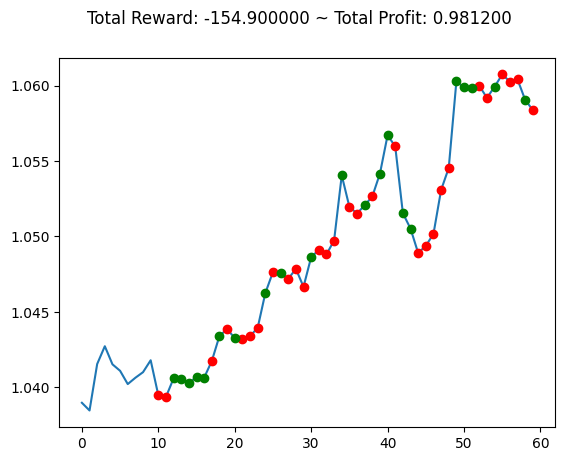

In [4]:

plt.cla()
env.render_all()
plt.show()